In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import io

# Loading data

In [4]:
samps = set()
with open("test/sampleids.txt") as f:
    line_ = f.readline()
    while line_:
        line = line_[:-1]
        samps.add(line)
        line_ = f.readline()

vdbi = pd.read_csv("test/reference/virus_dumydb.fa.fai", sep="\t", names=["chrom", "len", "offset", "linesize", "fulllinesize"]).set_index("chrom")

In [5]:
import numpy as np

dt_fdf = np.dtype([
    ('sample', np.uint16),
    ('qseqid', np.uint64),
    ('flag', np.uint16),
    ('mapq', np.uint8),
    ('hgchrom', np.dtype('S2')),       # <- fixed
    ('hgpos', np.uint32),
    ('hgmatechrom', np.dtype('S2')),   # <- fixed
    ('hgmatepos', np.uint32),
    ('sseqid', np.uint16),
    ('pident', np.uint16),
    ('length', np.uint8),
    ('mismatch', np.uint8),
    ('gapopen', np.uint8),
    ('qstart', np.uint8),
    ('qend', np.uint8),
    ('sstart', np.uint32),
    ('send', np.uint32),
    ('evalue', np.int16),
    ('bitscore', np.uint16),
])


In [6]:
chroms = pd.read_csv("test/reference/21_Homo_sapiens.GRCh38.dna_sm.primary_assembly.fa.fai", sep="\t", names=["chrom", "len", "offset", "linesize", "fulllinesize"]).set_index("chrom")
chroms

,len,offset,linesize,fulllinesize
chrom,,,,
21,35817086,4,60,61


In [7]:
# FIX
chrom_to_chromid = {str(k).encode("utf8"): i for i, k in enumerate(chroms.index)}
chromid_to_chrom = {i: str(k) for i, k in enumerate(chroms.index)}

# END FIX
# chrom_to_chromid = {bytes(k, "utf8"): i for i, k in enumerate(chroms.index)}
# chromid_to_chrom = {i: k for i, k in enumerate(chroms.index)}

In [10]:
version = "000"
filename_base = f"viralsummary_{version}.{{}}.parquet"
faix_genomes = pd.read_csv("test/reference/virus_dumydb.fa.fai", sep="\t", names=["id", "len", "start", "linesize", "linesize2"])
idx_genomes = faix_genomes["id"].to_dict()
faidx_genomes = faix_genomes.set_index("id")
idx_samples = pd.read_csv("test/expanded_sampleids.txt", sep="\t", names=["id"])["id"].to_dict()

In [13]:
df = pd.read_parquet(filename_base.format("sample_vs_virus"))
cm = pd.read_parquet(filename_base.format("comappings"))
cov_df = pd.read_parquet(filename_base.format("f4_sector_counts"))
rcounts = pd.read_parquet(filename_base.format("raw_counts"))
unique_bitscores = pd.read_parquet(filename_base.format("unique_bitscores"))

df = df[df["sample"].isin(samps)]

## Getting Species Names

In [14]:
import requests
import xml.etree.ElementTree as ET

In [15]:
base = "https://130.14.29.110/entrez/eutils/" # For some reason NCBI connection fails by URL
batch_size = 100

hpv_db = set(pd.read_csv("test/reference/494-HPV.fasta.fai", sep="\t", names=["chrom", "len", "offset", "linesize", "fulllinesize"])["chrom"].to_list())
genomes = df["sseqid"].unique()
genome_codes = {g: g.split("|")[1] if g in hpv_db else g for g in genomes}
genome_codes_back = {v: k for k, v in genome_codes.items()}
genome_codes_list = list(genome_codes.values())
conv = {}
for i in range(int(np.ceil(len(genome_codes_list)/batch_size))):
    root = ET.fromstring(requests.get(
        base + f"efetch.fcgi?db=nuccore&id={','.join(genome_codes_list[i*batch_size:(i+1)*batch_size])}&retmode=xml",
        verify=False, headers={"Host": "eutils.ncbi.nlm.nih.gov"}).content)
    def ochain(x, f):
        return [] if type(x) == type(None) else f(x)

    for k, v in {
        s.findtext("GBSeq_accession-version"): {
            "name": s.findtext("GBSeq_source"),
            "taxon": {
                f.findtext("GBFeature_key"): {
                    q.findtext("GBQualifier_name"): q.findtext("GBQualifier_value")
                    for q in ochain(f.find("GBFeature_quals"), lambda x: x.findall("GBQualifier"))
                }.get("db_xref")
                for f in ochain(s.find("GBSeq_feature-table"), lambda x: x.findall("GBFeature"))
            }.get("source")
        }
        for s in root.findall("GBSeq")
    }.items():
        if k in genome_codes_back:
            k_conv = genome_codes_back[k]
        else:
            k_conv = genome_codes_back[k.split(".")[0]]
        conv[k_conv] = v

for k in hpv_db:
    conv[k] = {
        "name": "Human papillomavirus",
        "taxon": "taxon:10566"
    }

conv_df = pd.DataFrame(conv).T.loc[genomes]
conv_df

/home/iaguilar/miniforge3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host '130.14.29.110'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,name,taxon
NC_007767.1,Hyphantria cunea nucleopolyhedrovirus,taxon:28288
NC_007921.1,Agrotis segetum nucleopolyhedrovirus A,taxon:1962501
NC_008030.1,Nile crocodilepox virus,taxon:1285600
NC_008168.1,Choristoneura fumiferana granulovirus,taxon:56947
NC_008187.1,Invertebrate iridescent virus 3,taxon:345201
...,...,...
NC_012783.2,Cercopithecine betaherpesvirus 5 (CeHV-5; GMCM...,taxon:50292
NC_016447.1,Aotine betaherpesvirus 1 (AoHV-1; OMCMV),taxon:50290
NC_016448.1,Saimiriine betaherpesvirus 4 (Squirrel monkey ...,taxon:1535247
NC_014564.2,Turkey adenovirus 1,taxon:878329


# Analysis

## Clusters

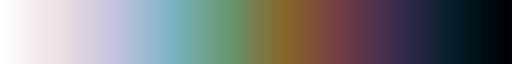

In [16]:
import matplotlib as mpl
colors = np.array(
      [[ 0.        ,  0.        ,  0.        ],
       [ 0.01004981,  0.11452213,  0.16000801],
       [ 0.2240929 ,  0.17151985,  0.31271444],
       [ 0.45906885,  0.23298207,  0.27229556],
       [ 0.53029992,  0.40270836,  0.16905967],
       [ 0.40071412,  0.59913422,  0.44094425],
       [ 0.48088811,  0.70171606,  0.7724891 ],
       [ 0.77736204,  0.76633265,  0.87810003],
       [ 0.93191211,  0.88219357,  0.89452719],
       [ 1, 1, 1 ]])
cmap_li = mpl.colors.LinearSegmentedColormap.from_list("mycmap", list(reversed(colors)))
cmap_li_10 = mpl.colors.ListedColormap(list(reversed(colors)))
cmap_li.set_under((1.,1.,1.,0.))
cmap_li

In [17]:
genome_names = {}

with open("test/reference/virus_dumydb.fa", "rt") as f:
    # (genome_id, approximate_offset_positon_of_genome_name)
    for g, p in zip(vdbi.index, np.r_[0,(((vdbi["len"]/vdbi["linesize"]).astype(int)+1)*(vdbi["fulllinesize"]-vdbi["linesize"])+vdbi["len"]+vdbi["offset"]).values[:-1]]):       
        if g in hpv_db:
            genome_names[g] = f"HPV ({g.split('|')[1]})"
        elif g in conv:
            genome_names[g] = conv[g]["name"]
        else:
            f.seek(p,0)
            l = ""
            while l == "":
                l = f.readline().strip()
            l = l[1:]
            lspl = l.split(" ")
            if len(lspl) > 1:
                genome_names[g] = " ".join(lspl[1:])
            else:
                genome_names[g] = l
genome_names = pd.Series(genome_names)
genome_names_orig = genome_names
genome_names = genome_names.str.extract(r"\(([^\) ]+ [^\)]*[Vv]irus[^\)]*)\)")[0].fillna(genome_names.str.replace("[Vv]irus.*$", "virus", regex=True).replace("(,)? complete ([A-Za-z])+", "", regex=True))
genome_names

NC_007748.1    Peruvian horse sickness virus
NC_007749.1    Peruvian horse sickness virus
NC_007750.1    Peruvian horse sickness virus
NC_007751.1    Peruvian horse sickness virus
NC_007752.1    Peruvian horse sickness virus
                           ...              
NC_014564.2                Turkey adenovirus
NC_016418.1         Halastavi arva RNA virus
NC_016517.1             Espirito Santo virus
NC_016518.1             Espirito Santo virus
NC_004156.2        Helicoverpa zea nudivirus
Name: 0, Length: 756, dtype: object

In [18]:
total_reads = rcounts.groupby("sseqid", observed=True, sort=False)["read_count"].sum().reindex(genomes).fillna(0).astype(int)
unique_reads = pd.Series(np.diag(cm.loc[genomes,genomes]), index=genomes)
unique_reads/total_reads

NC_007767.1    3.586207
NC_007921.1    2.357143
NC_008030.1    3.836735
NC_008168.1    4.000000
NC_008187.1    3.916667
                 ...   
NC_012783.2    3.875000
NC_016447.1    3.931034
NC_016448.1    3.920000
NC_014564.2    3.200000
NC_004156.2    4.000000
Length: 72, dtype: float64

In [19]:
pairs = pd.DataFrame(np.tril(cm.loc[genomes, genomes], k=-1), index=genomes, columns=genomes)
pairs += pairs.T

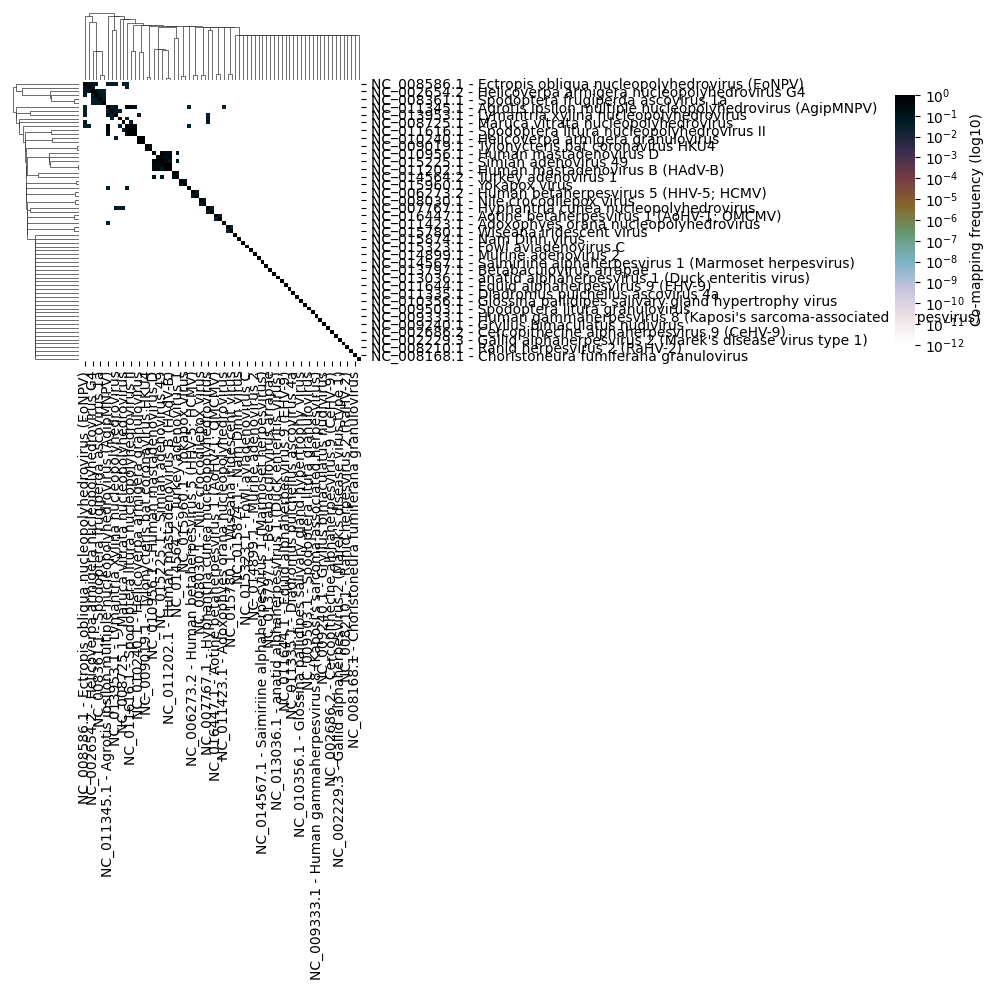

In [22]:
# 1) Build FMS with safe division
tot = total_reads.to_numpy()
pairs_arr = pairs.to_numpy()  # must be aligned square with same index/columns
den = tot[:, None] + tot[None, :] - pairs_arr

# Safe divide: where denominator > 0; else 0
with np.errstate(divide='ignore', invalid='ignore'):
    fms_arr = np.divide(pairs_arr, den, out=np.zeros_like(pairs_arr, dtype=float), where=(den > 0))

# 2) Put back into a DF and align to genomes (if needed)
fms = pd.DataFrame(fms_arr, index=pairs.index, columns=pairs.columns)
fms = fms.loc[genomes, genomes]  # your selection

# 3) Safe diagonal fill: unique_reads / total_reads (guard total=0)
diag_ratio = np.divide(unique_reads, total_reads, out=np.zeros_like(unique_reads, dtype=float), where=(total_reads > 0))
np.fill_diagonal(fms.to_numpy(), diag_ratio)

# 4) Labeling step (names on index/columns)
orig_indx = fms.index
fms.index = fms.index.astype(str) + " - " + fms.index.map(genome_names_orig).astype(str)
fms.columns = fms.columns.astype(str) + " - " + fms.columns.map(genome_names_orig).astype(str)

# 5) Clean up: replace non-finite, clip to [0, 1], then add eps for log
fms = fms.replace([np.inf, -np.inf], np.nan).fillna(0.0)
fms = fms.clip(lower=0.0, upper=1.0)        # co-mapping frequency should be in [0,1]
eps = 1e-12
M = np.log10(fms + eps)                     # now guaranteed finite
vmin, vmax = np.log10(eps), 0.0             # consistent with the transformation

# 6) Ensure matrix is at least 2x2 for clustering on both axes
row_cluster = M.shape[0] >= 2
col_cluster = M.shape[1] >= 2

# 7) Final guard (SciPy requires all finite)
assert np.isfinite(M.values).all(), "Non-finite values remain in the matrix."

# 8) Plot
cg = sns.clustermap(
    M, cmap=cmap_li, vmin=vmin, vmax=vmax, method="single", figsize=(10, 10),
    row_cluster=row_cluster, col_cluster=col_cluster,
    cbar_kws={"label": "Co-mapping frequency (log10)"},
    cbar_pos=(0.90, 0.65, 0.020, 0.25),
)

# Nicely formatted colorbar ticks at powers of 10
ticks = np.arange(np.ceil(vmin), np.floor(vmax) + 1)  # e.g., -12..0
cg.ax_cbar.set_yticks(ticks, [f"$10^{{{int(t)}}}$" for t in ticks])

# Restore original labels if you want them later
fms.index = orig_indx
fms.columns = orig_indx


In [23]:
from scipy.cluster import hierarchy

cluster_method = "height"

if cluster_method == "connected":
    from scipy import sparse
    n_clusters, viruscluster = sparse.csgraph.connected_components(sparse.csr_matrix(fms>1e-7), directed=False)
    viruscluster = pd.Series(viruscluster.astype(str), index=fms.index, name="viruscluster")
elif cluster_method == "height":
    ddgrm = hierarchy.dendrogram(cg.dendrogram_col.calculated_linkage, no_plot=True, color_threshold=36)
    llc = None
    n_clusters = 0
    viruscluster = {}
    for lc, lv in zip(ddgrm["leaves_color_list"], ddgrm["leaves"]):
        if lc == "C0" or llc != lc:
            llc = lc
            n_clusters += 1
        viruscluster[genomes[lv]] = str(n_clusters)
    n_clusters += 1
    viruscluster = pd.Series(viruscluster, index=fms.index, name="viruscluster")

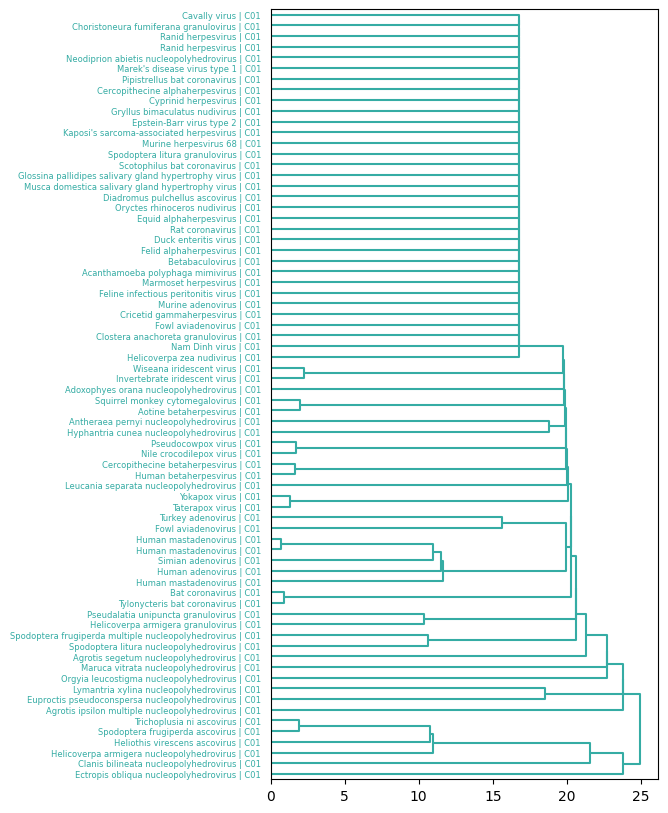

In [25]:
lli = {i: i for i in range(len(genomes))}
for i, (v1,v2) in enumerate(cg.dendrogram_col.calculated_linkage[:, :2].astype(int)):
    lli[i + len(genomes)] = None if None in [lli[v1], lli[v2]] else (
        lli[v1] if
            genomes[lli[v1]] in viruscluster and
            genomes[lli[v2]] in viruscluster and
            viruscluster[genomes[lli[v1]]] == viruscluster[genomes[lli[v2]]] else None
    )

pal = sns.husl_palette(n_clusters)
leaf_colors = {k: f'#{np.sum((np.array(pal[int(v)])*255).astype(int)*[2**16,2**8,1]):06X}' for k,v in viruscluster.items()}

def color_leaves(i):
    lidx = lli[i]
    if type(lidx) == type(None):
        return "gray"
    g = genomes[lidx]
    if g in leaf_colors:
        return leaf_colors[g]
    else:
        return "gray"
viruscluster_colors = pd.Series([pal[i] for i in range(n_clusters)], index=np.arange(n_clusters).astype(str))

plt.figure(figsize=(5,10))
ddrg = hierarchy.dendrogram(cg.dendrogram_col.calculated_linkage, link_color_func=color_leaves, orientation='right')
plt.gca().set_yticklabels(f'{genome_names[genomes[i]]} | C{viruscluster[genomes[i]]:>02}' for i in ddrg["leaves"])
for leafidx, lab in zip(ddrg["leaves"], plt.gca().get_yticklabels()):
    g = genomes[leafidx]
    lab.set_color(leaf_colors[g])


In [27]:
# assigning a human-readable name to each cluster
viruscluster_best = (
    (genome_names.loc[genomes].str.contains("human", flags=re.IGNORECASE)*4 + genome_names.loc[genomes].str.contains("H[A-Z]+")*2)
    + 1-np.exp(-df["mean_bitscore"].groupby(df["sseqid"], observed=True, sort=False).mean()/100)
).rename("x").to_frame().join(unique_bitscores.set_index("sseqid")).T.prod().T.rename("x").to_frame().join(viruscluster).groupby("viruscluster")["x"].idxmax()
viruscluster_name = viruscluster_best.map(genome_names)
viruscluster_name

viruscluster
1    Human mastadenovirus
Name: x, dtype: object

## Figures

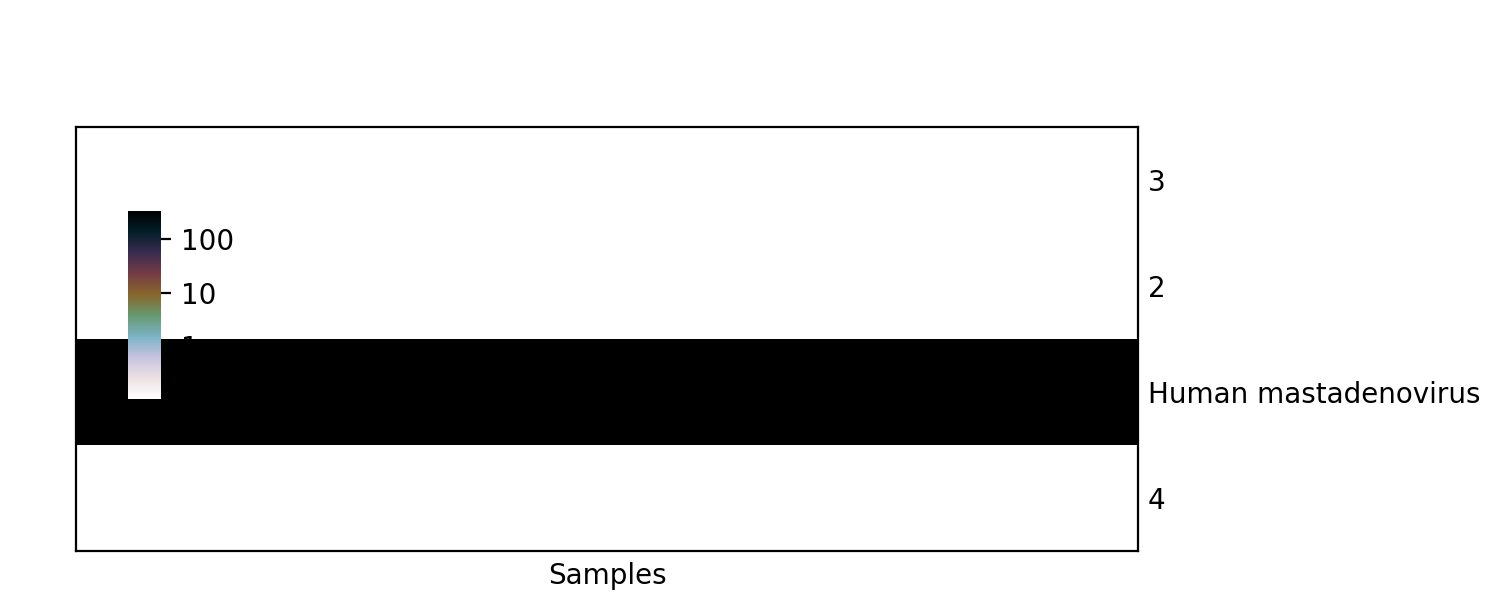

In [29]:
# Build pivot
viruscluster_table = (
    df.merge(pd.Series(viruscluster, name="viruscluster").rename_axis("sseqid"),
             on="sseqid", how="left")
      .set_index("sseqid")
      .groupby(["sample", "viruscluster"], observed=True)["read_count"]
)
viruscluster_samplebests = viruscluster_table.idxmax().rename("sseqid")
viruscluster_table = viruscluster_table.max()

viruscluster_table_pivot = (
    viruscluster_table.reset_index()
    .pivot(index="sample", columns="viruscluster", values="read_count")
    .fillna(0)
    .astype(int)
)

# Ensure column dtype is str before reindexing
viruscluster_table_pivot.columns = viruscluster_table_pivot.columns.astype(str)

# Force the desired cluster order; add missing clusters as 0
desired = ["3","2","1","4"]
viruscluster_table_pivot = viruscluster_table_pivot.reindex(columns=desired, fill_value=0)

# Transform for plotting: rows=clusters, cols=samples
eps = 1e-1
plot_mat = np.log10(viruscluster_table_pivot.T + eps) \
            .rename(index=viruscluster_name) \
            .rename_axis(index="", columns="Samples")

# Safety checks: make sure we have something to cluster/plot
n_rows, n_cols = plot_mat.shape  # rows=clusters, cols=samples
if n_rows == 0:
    raise ValueError("No clusters to plot after reindex. Check that viruscluster has labels in ['3','2','1','4'].")
if n_cols == 0:
    raise ValueError("No samples to plot. Check that 'sample' survives the merge/groupby.")

# Cluster columns only if we have at least 2 samples
col_cluster_flag = n_cols >= 2
row_cluster_flag = False  # as you had

# Use log-scale vmin/vmax consistent with the transformed data
vmin = np.log10(eps)  # -1
vmax = float(np.nanmax(plot_mat.values))

cma = sns.clustermap(
    plot_mat,
    cmap=cmap_li,
    vmin=vmin, vmax=vmax,
    figsize=(7.65, 3.15),
    cbar_pos=(0.09, 0.35, 0.022, 0.3),
    row_cluster=row_cluster_flag,
    col_cluster=col_cluster_flag,
    dendrogram_ratio=(0.05, 0.2),
    xticklabels=False
)

# Flip x limits
cma.ax_heatmap.set_xlim(*list(cma.ax_heatmap.get_xlim())[::-1])
if col_cluster_flag:
    cma.ax_col_dendrogram.set_xlim(*list(cma.ax_col_dendrogram.get_xlim())[::-1])

# Styling
cma.ax_heatmap.yaxis.set_tick_params(length=0)
for s in cma.ax_heatmap.spines.values():
    s.set_visible(True)

# Ticks for log10 colorbar (e.g., -1..vmax)
ticks = np.arange(np.ceil(vmin), np.floor(vmax) + 1)
cma.ax_cbar.set_yticks(ticks, ["0"] + [f"{10**int(t):,}" for t in ticks][1:])

cma.figure.set_dpi(200)
cma.savefig("virusclusters.pdf")


Text(0.5, 0, 'Number of reads per sample')

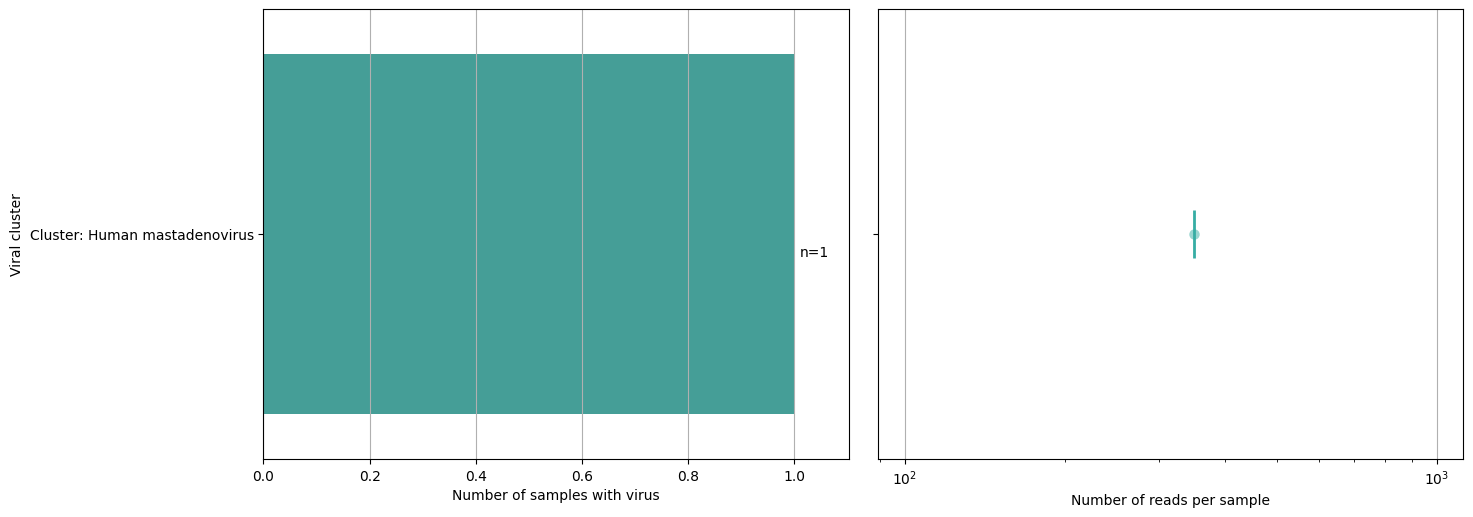

In [31]:
(fig, axs) = plt.subplots(1,2, figsize=(12,4.5), sharey=True)
fig.subplots_adjust(0,0,1,1,0.05,0.05)
viruscluster_summary = viruscluster_table.reset_index().groupby("viruscluster")["sample"].nunique().rename("samples").sort_values(ascending=False)
sns.barplot(
    data=viruscluster_summary.reset_index(), x="samples", y="viruscluster", order=viruscluster_summary.index, hue="viruscluster", palette=viruscluster_colors.to_dict(), ax=axs[0]
)
sns.stripplot(
    data=viruscluster_table.reset_index(), x="read_count", y="viruscluster", order=viruscluster_summary.index, hue="viruscluster", palette=viruscluster_colors.to_dict(), ax=axs[1],
    alpha=0.5, jitter=0.10, size=7.5
)
sns.pointplot(
    data=viruscluster_table.reset_index(), x="read_count", y="viruscluster", order=viruscluster_summary.index, hue="viruscluster", palette=viruscluster_colors.to_dict(), ax=axs[1],
    errorbar=None, linestyle=None, marker="|", markersize=35, markeredgewidth=2, estimator='median'
)

oxl = axs[0].get_xlim()
for p, label in zip(axs[0].patches, viruscluster_summary.values):
    axs[0].annotate(f"n={label}", (p.get_width() + oxl[1]*0.01, p.get_y()+0.45), va="baseline")


axs[0].grid(axis="x")
axs[1].grid(axis="x")
axs[0].set_xlim(oxl[0], oxl[1]*1.05)
axs[1].set_xscale("log")
axs[0].set_yticks(axs[0].get_yticks())
axs[0].set_yticklabels(["Cluster: " + viruscluster_name.loc[v.get_text()] for v in axs[0].get_yticklabels()])
axs[0].set_xlabel("Number of samples with virus")
axs[0].set_ylabel("Viral cluster")
axs[1].set_xlabel("Number of reads per sample")

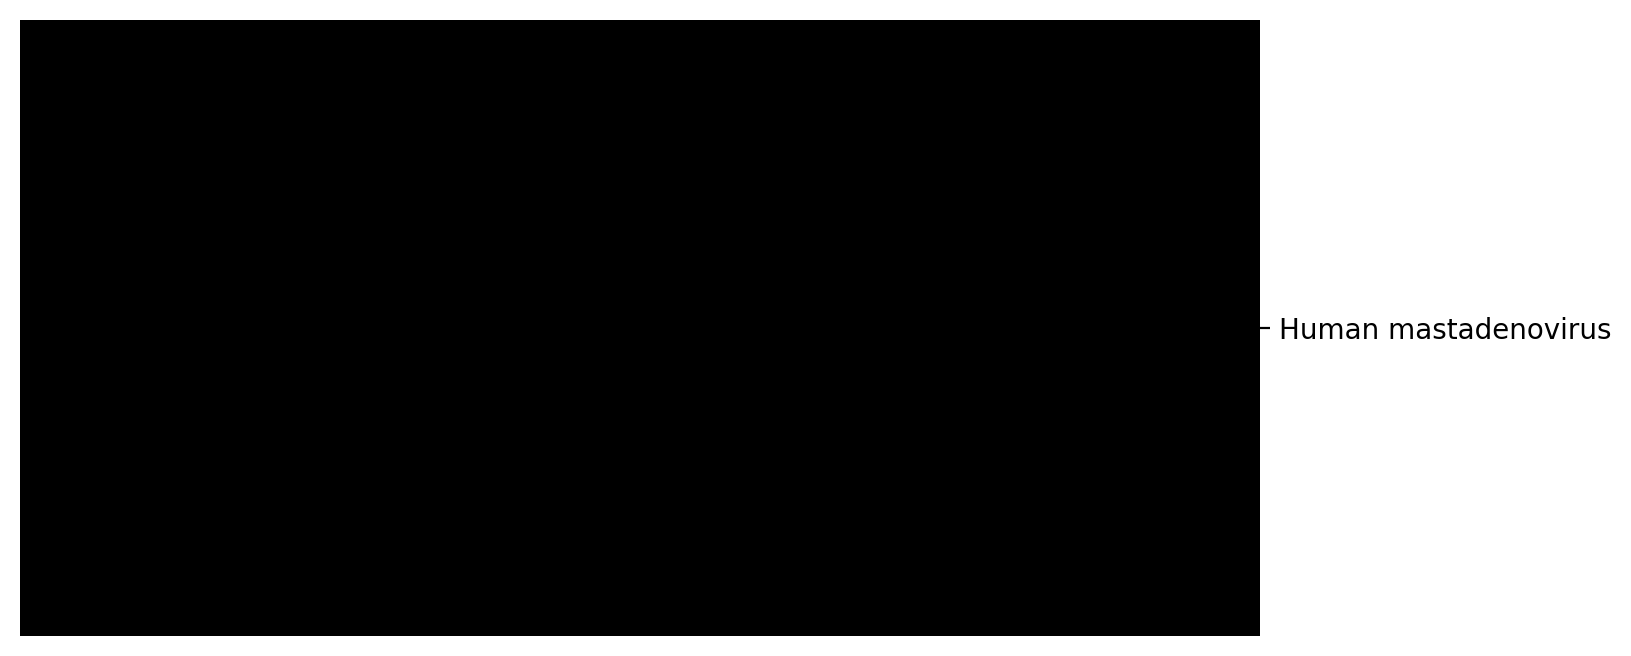

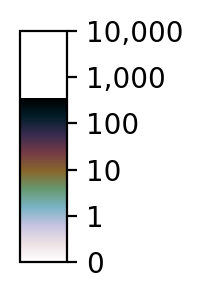

In [32]:
from matplotlib.gridspec import GridSpec

hmdata = np.log10(viruscluster_table_pivot.reindex(columns=viruscluster_summary.index).sort_values(list(viruscluster_summary.index), ascending=False).rename(columns=viruscluster_name)+1e-6)
plt.figure(figsize=(8,4), dpi=200)
sns.heatmap(hmdata.T, cmap=cmap_li, vmin=1e-1, cbar=False, xticklabels=False)
plt.gca().yaxis.tick_right()
plt.yticks(rotation=0)
plt.xlabel("")
plt.ylabel("")
plt.show()
plt.figure(figsize=(0.3,1.5), dpi=200)
norm = plt.Normalize(vmin=-1, vmax=np.max(hmdata))
scm = plt.cm.ScalarMappable(cmap=cmap_li, norm=norm)
scm.set_array([])
plt.colorbar(scm, cax=plt.gca(), orientation="vertical")
plt.yticks(np.arange(-1, 5), [0] + list(("{:,}".format(10**i) for i in range(5))))
plt.show()